In [1]:
from init import *

In [2]:
from transformations import (train_transforms,test_transforms,no_transforms)
from trainer import Trainer
from tester import Tester
from utlis import visualize_data,show_misclassified_images,device,is_cuda
from viz import plot_class_distribution, plot_confusion_matrix, plot_curves
from dataloader import CIFAR10Dataset,CIFAR10DataLoader
from models import ConvLayer,TransBlock,DepthwiseConvLayer

In [3]:
torch.cuda.amp.autocast(enabled=True, dtype=torch.float16, cache_enabled=False)

In [4]:
# Augmentation
atrain_dataset = CIFAR10Dataset(root='../data/',train=True,Atransforms=train_transforms,download=False)
atest_dataset  = CIFAR10Dataset(root='../data/',train=False,Atransforms=test_transforms,download=False)
acifar = CIFAR10DataLoader(batch_size=512,is_cuda_available=True)
atrain_loader, atest_loader = acifar.get_loader(atrain_dataset,atest_dataset)


# No Augmentation
train_dataset = CIFAR10Dataset(root='../data/',train=True,Atransforms=test_transforms,download=False)
test_dataset  = CIFAR10Dataset(root='../data/',train=False,Atransforms=test_transforms,download=False)
cifar = CIFAR10DataLoader(batch_size=512,is_cuda_available=True)
train_loader, test_loader = cifar.get_loader(train_dataset,test_dataset)

In [5]:
# dp_rate = 0.01
# ip = torch.rand(size=(1,16,8,8))

# x =      ConvLayer(inc=8,outc=24,k=3,p=1,s=1,d=1,dp_rate=dp_rate); print(x(ip).shape)

# x =      DepthwiseConvLayer(8,24,s=1,p=1,dp_rate=0.1) ;print(x(ip).shape)

# x =      ConvLayer(inc=8,outc=24,k=3,p=1,s=1,d=1,dp_rate=dp_rate); print(x(ip).shape)   # Dilated Conv

# x =      TransBlock(16,1,p=1,s=2); print(x(ip).shape)

**small model with no augmentation**

In [6]:
dp_rate = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = ConvLayer(inc=3,outc=8,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        
        self.conv2 = ConvLayer(inc=8,outc=24,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep2  = DepthwiseConvLayer(inc=8,outc=24,p=1,s=1,dp_rate=dp_rate)
        self.dil2  = ConvLayer(inc=8,outc=24,k=3,p=2,s=1,d=2,dp_rate=dp_rate)

        self.conv3 = ConvLayer(inc=24,outc=68,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep3  = DepthwiseConvLayer(inc=24,outc=68,p=1,s=1,dp_rate=dp_rate)
        self.dil3  = ConvLayer(inc=24,outc=68,k=3,p=2,s=1,d=2,dp_rate=dp_rate)

        self.trans4 = TransBlock(100,16,p=0,s=2)


        self.conv_ = ConvLayer(16,32,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        
        self.conv5 = ConvLayer(inc=32,outc=48,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep5  = DepthwiseConvLayer(inc=32,outc=48,p=1,s=1,dp_rate=dp_rate)
        self.dil5  = ConvLayer(inc=32,outc=48,k=3,p=2,s=1,d=2,dp_rate=dp_rate)

        self.conv6 = ConvLayer(inc=48,outc=56,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep6  = DepthwiseConvLayer(inc=48,outc=56,p=1,s=1,dp_rate=dp_rate)
        self.dil6  = ConvLayer(inc=48,outc=56,k=3,p=2,s=1,d=2,dp_rate=dp_rate)
      
        self.trans7 = TransBlock(104,16,p=0,s=2)
        self.trans_ = TransBlock(16,16,p=0,s=2)
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.out = TransBlock(inc=16,outc=10,p=0,s=1)
    
    
    def forward(self,x):        
        x1 = self.conv1(x)
        x2 = self.dep2(x1) + self.conv2(x1) + self.dil2(x1) 
        x3 = self.dep3(x2) + self.conv3(x2) + self.dil3(x2) 
        x4 = torch.concat((x1,x2,x3),dim=1)
        x = self.trans4(x4)

        x = self.conv_(x)
        x5 = self.conv5(x) + self.dep5(x) + self.dil5(x)
        x6 = self.conv6(x5)+ self.dep6(x5)+ self.dil6(x5)
        x7 = torch.concat((x5,x6),dim=1)
        x  = self.trans7(x7)
        x  = self.trans_(x)
        x = self.gap(x)
        x = self.out(x)
        return  F.log_softmax(x.view(-1,10), dim=1)

model = Net().to(device)

In [7]:
summary(model=model,input_size=(1,3,32,32),device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─ConvLayer: 1-1                         [1, 8, 32, 32]            --
│    └─Sequential: 2-1                   [1, 8, 32, 32]            --
│    │    └─Conv2d: 3-1                  [1, 8, 32, 32]            216
│    │    └─BatchNorm2d: 3-2             [1, 8, 32, 32]            16
│    │    └─ReLU: 3-3                    [1, 8, 32, 32]            --
│    │    └─Dropout2d: 3-4               [1, 8, 32, 32]            --
├─DepthwiseConvLayer: 1-2                [1, 24, 32, 32]           --
│    └─Sequential: 2-2                   [1, 24, 32, 32]           --
│    │    └─Conv2d: 3-5                  [1, 8, 32, 32]            72
│    │    └─Conv2d: 3-6                  [1, 24, 32, 32]           192
│    │    └─ReLU: 3-7                    [1, 24, 32, 32]           --
│    │    └─BatchNorm2d: 3-8             [1, 24, 32, 32]           48
│    │    └─D

C:\Users\muthu\Documents\TSAI\session 9\utlis.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


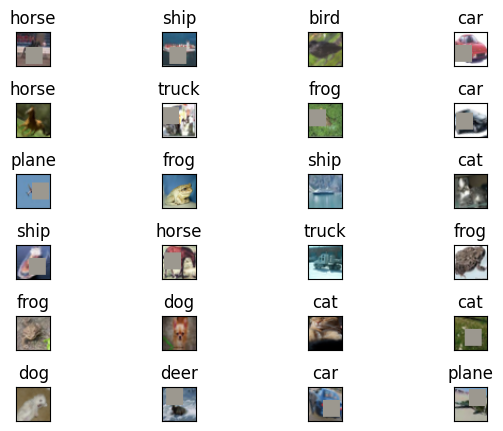

In [8]:
visualize_data(atrain_loader,classes=acifar.classes,num_figures=24)

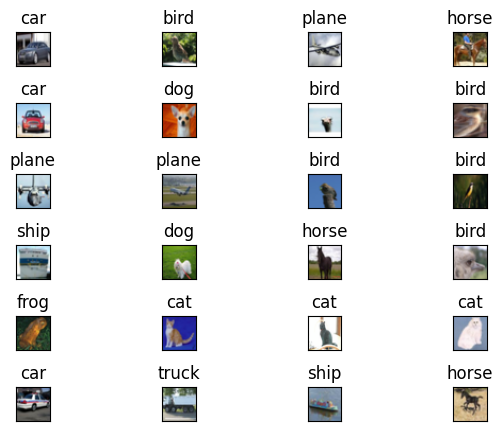

In [9]:
visualize_data(train_loader,classes=cifar.classes,num_figures=24)

In [10]:
prev_test_loss = float('inf')

if os.path.isfile(r"C:\Users\muthu\Documents\TSAI\session 9\bmodels\model1.pth"): model.load_state_dict(torch.load(r"C:\Users\muthu\Documents\TSAI\session 9\bmodels\model1.pth"))

optimizer = optim.SGD(params=model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=3)
criterion = nn.NLLLoss()
trainer = Trainer(model=model, train_loader=train_loader, optimizer=optimizer, criterion=criterion, device=device)
tester = Tester(model=model, test_loader=test_loader,criterion=criterion, device=device)

for epoch in range(1, 101):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(obj=model.state_dict(),f='./bmodels/model.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.1 | Loss = 1.64 | Batch = 97 | Accuracy = 29.81: 100%|███| 98/98 [00:47<00:00,  2.06it/s]


Test set: Average loss: 0.0033, Accuracy: 3789/10000 (37.89%)


EPOCH = 2 | LR = 0.1 | Loss = 1.42 | Batch = 97 | Accuracy = 41.69: 100%|███| 98/98 [00:46<00:00,  2.11it/s]


Test set: Average loss: 0.0028, Accuracy: 4866/10000 (48.66%)


EPOCH = 3 | LR = 0.1 | Loss = 1.36 | Batch = 97 | Accuracy = 47.40: 100%|███| 98/98 [00:46<00:00,  2.10it/s]


Test set: Average loss: 0.0026, Accuracy: 4987/10000 (49.87%)


EPOCH = 4 | LR = 0.1 | Loss = 1.25 | Batch = 97 | Accuracy = 51.63: 100%|███| 98/98 [00:46<00:00,  2.11it/s]


Test set: Average loss: 0.0024, Accuracy: 5622/10000 (56.22%)


EPOCH = 5 | LR = 0.1 | Loss = 1.29 | Batch = 97 | Accuracy = 54.90: 100%|███| 98/98 [00:45<00:00,  2.13it/s]


Test set: Average loss: 0.0022, Accuracy: 6050/10000 (60.50%)


EPOCH = 6 | LR = 0.1 | Loss = 1.08 | Batch = 97 | Accuracy = 57.74: 100%|███| 98/98 [00:45<00:00,  2.14it/s]


Test set: Average loss: 0.0021, Accuracy: 6252/10000 (62.52%)


EPOCH = 7 | LR = 0.1 | Loss = 1.12 | Batch = 97 | Accuracy = 59.61: 100%|███| 98/98 [00:45<00:00,  2.14it/s]


Test set: Average loss: 0.0021, Accuracy: 6197/10000 (61.97%)


EPOCH = 8 | LR = 0.1 | Loss = 1.00 | Batch = 97 | Accuracy = 61.26: 100%|███| 98/98 [00:46<00:00,  2.13it/s]


Test set: Average loss: 0.0019, Accuracy: 6466/10000 (64.66%)


EPOCH = 9 | LR = 0.1 | Loss = 1.02 | Batch = 97 | Accuracy = 62.93: 100%|███| 98/98 [00:46<00:00,  2.12it/s]


Test set: Average loss: 0.0018, Accuracy: 6724/10000 (67.24%)


EPOCH = 10 | LR = 0.1 | Loss = 1.08 | Batch = 97 | Accuracy = 64.31: 100%|██| 98/98 [00:46<00:00,  2.13it/s]


Test set: Average loss: 0.0018, Accuracy: 6757/10000 (67.57%)


EPOCH = 11 | LR = 0.1 | Loss = 0.92 | Batch = 97 | Accuracy = 65.31: 100%|██| 98/98 [00:46<00:00,  2.13it/s]


Test set: Average loss: 0.0018, Accuracy: 6861/10000 (68.61%)


EPOCH = 12 | LR = 0.1 | Loss = 0.99 | Batch = 97 | Accuracy = 66.90: 100%|██| 98/98 [00:48<00:00,  2.01it/s]


Test set: Average loss: 0.0018, Accuracy: 6880/10000 (68.80%)


EPOCH = 13 | LR = 0.1 | Loss = 0.87 | Batch = 97 | Accuracy = 67.78: 100%|██| 98/98 [00:45<00:00,  2.15it/s]


Test set: Average loss: 0.0016, Accuracy: 7118/10000 (71.18%)


EPOCH = 14 | LR = 0.1 | Loss = 0.96 | Batch = 97 | Accuracy = 68.76: 100%|██| 98/98 [00:45<00:00,  2.13it/s]


Test set: Average loss: 0.0016, Accuracy: 7063/10000 (70.63%)


EPOCH = 15 | LR = 0.1 | Loss = 0.82 | Batch = 97 | Accuracy = 69.34: 100%|██| 98/98 [00:45<00:00,  2.14it/s]


Test set: Average loss: 0.0017, Accuracy: 7055/10000 (70.55%)


EPOCH = 16 | LR = 0.1 | Loss = 0.84 | Batch = 97 | Accuracy = 70.35: 100%|██| 98/98 [00:45<00:00,  2.14it/s]


Test set: Average loss: 0.0015, Accuracy: 7238/10000 (72.38%)


EPOCH = 17 | LR = 0.1 | Loss = 0.93 | Batch = 97 | Accuracy = 71.39: 100%|██| 98/98 [00:45<00:00,  2.14it/s]


Test set: Average loss: 0.0015, Accuracy: 7415/10000 (74.15%)


EPOCH = 18 | LR = 0.1 | Loss = 0.83 | Batch = 97 | Accuracy = 71.92: 100%|██| 98/98 [00:45<00:00,  2.15it/s]


Test set: Average loss: 0.0015, Accuracy: 7346/10000 (73.46%)


EPOCH = 19 | LR = 0.1 | Loss = 0.82 | Batch = 97 | Accuracy = 72.65: 100%|██| 98/98 [00:45<00:00,  2.13it/s]


Test set: Average loss: 0.0015, Accuracy: 7322/10000 (73.22%)


EPOCH = 20 | LR = 0.1 | Loss = 0.73 | Batch = 97 | Accuracy = 72.93: 100%|██| 98/98 [00:45<00:00,  2.13it/s]


Test set: Average loss: 0.0014, Accuracy: 7465/10000 (74.65%)


EPOCH = 21 | LR = 0.1 | Loss = 0.84 | Batch = 97 | Accuracy = 73.84: 100%|██| 98/98 [00:45<00:00,  2.13it/s]


Test set: Average loss: 0.0014, Accuracy: 7548/10000 (75.48%)


EPOCH = 22 | LR = 0.1 | Loss = 0.76 | Batch = 97 | Accuracy = 74.20: 100%|██| 98/98 [00:45<00:00,  2.14it/s]


Test set: Average loss: 0.0015, Accuracy: 7440/10000 (74.40%)


EPOCH = 23 | LR = 0.1 | Loss = 0.71 | Batch = 97 | Accuracy = 74.56: 100%|██| 98/98 [00:45<00:00,  2.13it/s]


Test set: Average loss: 0.0014, Accuracy: 7606/10000 (76.06%)


EPOCH = 24 | LR = 0.1 | Loss = 0.70 | Batch = 97 | Accuracy = 75.22: 100%|██| 98/98 [00:45<00:00,  2.14it/s]


Test set: Average loss: 0.0014, Accuracy: 7574/10000 (75.74%)


EPOCH = 25 | LR = 0.1 | Loss = 0.74 | Batch = 97 | Accuracy = 75.65: 100%|██| 98/98 [00:45<00:00,  2.14it/s]


Test set: Average loss: 0.0014, Accuracy: 7466/10000 (74.66%)


EPOCH = 26 | LR = 0.1 | Loss = 0.63 | Batch = 97 | Accuracy = 76.12: 100%|██| 98/98 [00:45<00:00,  2.14it/s]


Test set: Average loss: 0.0013, Accuracy: 7637/10000 (76.37%)


EPOCH = 27 | LR = 0.1 | Loss = 0.71 | Batch = 97 | Accuracy = 76.38: 100%|██| 98/98 [00:45<00:00,  2.15it/s]


Test set: Average loss: 0.0014, Accuracy: 7496/10000 (74.96%)


EPOCH = 28 | LR = 0.1 | Loss = 0.67 | Batch = 97 | Accuracy = 77.04: 100%|██| 98/98 [00:45<00:00,  2.15it/s]


Test set: Average loss: 0.0014, Accuracy: 7581/10000 (75.81%)


EPOCH = 29 | LR = 0.1 | Loss = 0.61 | Batch = 97 | Accuracy = 77.09: 100%|██| 98/98 [00:45<00:00,  2.14it/s]


Test set: Average loss: 0.0014, Accuracy: 7601/10000 (76.01%)


EPOCH = 30 | LR = 0.1 | Loss = 0.66 | Batch = 97 | Accuracy = 77.72: 100%|██| 98/98 [00:45<00:00,  2.15it/s]


Test set: Average loss: 0.0013, Accuracy: 7713/10000 (77.13%)


EPOCH = 31 | LR = 0.1 | Loss = 0.73 | Batch = 97 | Accuracy = 77.83: 100%|██| 98/98 [00:45<00:00,  2.15it/s]


Test set: Average loss: 0.0014, Accuracy: 7648/10000 (76.48%)


EPOCH = 32 | LR = 0.1 | Loss = 0.63 | Batch = 97 | Accuracy = 78.09: 100%|██| 98/98 [00:46<00:00,  2.09it/s]


Test set: Average loss: 0.0013, Accuracy: 7756/10000 (77.56%)


EPOCH = 33 | LR = 0.1 | Loss = 0.66 | Batch = 97 | Accuracy = 78.36: 100%|██| 98/98 [00:45<00:00,  2.13it/s]


Test set: Average loss: 0.0013, Accuracy: 7745/10000 (77.45%)


EPOCH = 34 | LR = 0.1 | Loss = 0.64 | Batch = 97 | Accuracy = 78.57: 100%|██| 98/98 [00:45<00:00,  2.13it/s]


Test set: Average loss: 0.0013, Accuracy: 7835/10000 (78.35%)


EPOCH = 35 | LR = 0.1 | Loss = 0.58 | Batch = 97 | Accuracy = 78.84: 100%|██| 98/98 [00:46<00:00,  2.10it/s]


Test set: Average loss: 0.0013, Accuracy: 7718/10000 (77.18%)


EPOCH = 36 | LR = 0.1 | Loss = 0.66 | Batch = 97 | Accuracy = 79.17: 100%|██| 98/98 [00:46<00:00,  2.13it/s]


Test set: Average loss: 0.0013, Accuracy: 7799/10000 (77.99%)


EPOCH = 37 | LR = 0.1 | Loss = 0.52 | Batch = 97 | Accuracy = 79.03: 100%|██| 98/98 [00:45<00:00,  2.13it/s]


Test set: Average loss: 0.0013, Accuracy: 7805/10000 (78.05%)


EPOCH = 38 | LR = 0.010000000000000002 | Loss = 0.45 | Batch = 97 | Accuracy = 81.62: 100%|█| 98/98 [00:45<0


Test set: Average loss: 0.0012, Accuracy: 7920/10000 (79.20%)


EPOCH = 39 | LR = 0.010000000000000002 | Loss = 0.57 | Batch = 97 | Accuracy = 82.26: 100%|█| 98/98 [00:46<0


Test set: Average loss: 0.0012, Accuracy: 7904/10000 (79.04%)


EPOCH = 40 | LR = 0.010000000000000002 | Loss = 0.42 | Batch = 97 | Accuracy = 82.93: 100%|█| 98/98 [00:46<0


Test set: Average loss: 0.0012, Accuracy: 7911/10000 (79.11%)


EPOCH = 41 | LR = 0.010000000000000002 | Loss = 0.57 | Batch = 97 | Accuracy = 82.86: 100%|█| 98/98 [00:45<0


Test set: Average loss: 0.0012, Accuracy: 7968/10000 (79.68%)


EPOCH = 42 | LR = 0.010000000000000002 | Loss = 0.53 | Batch = 97 | Accuracy = 82.93: 100%|█| 98/98 [00:45<0


Test set: Average loss: 0.0012, Accuracy: 7945/10000 (79.45%)


EPOCH = 43 | LR = 0.010000000000000002 | Loss = 0.47 | Batch = 97 | Accuracy = 83.23: 100%|█| 98/98 [00:45<0


Test set: Average loss: 0.0012, Accuracy: 7938/10000 (79.38%)


EPOCH = 44 | LR = 0.010000000000000002 | Loss = 0.50 | Batch = 97 | Accuracy = 83.08: 100%|█| 98/98 [00:45<0


Test set: Average loss: 0.0012, Accuracy: 7934/10000 (79.34%)


EPOCH = 45 | LR = 0.010000000000000002 | Loss = 0.54 | Batch = 97 | Accuracy = 83.40: 100%|█| 98/98 [00:45<0


Test set: Average loss: 0.0012, Accuracy: 7945/10000 (79.45%)


EPOCH = 46 | LR = 0.0010000000000000002 | Loss = 0.40 | Batch = 97 | Accuracy = 83.64: 100%|█| 98/98 [00:45<


Test set: Average loss: 0.0012, Accuracy: 7960/10000 (79.60%)


EPOCH = 47 | LR = 0.0010000000000000002 | Loss = 0.46 | Batch = 97 | Accuracy = 83.55: 100%|█| 98/98 [00:45<


Test set: Average loss: 0.0012, Accuracy: 7961/10000 (79.61%)


EPOCH = 48 | LR = 0.0010000000000000002 | Loss = 0.39 | Batch = 97 | Accuracy = 83.38: 100%|█| 98/98 [00:45<


Test set: Average loss: 0.0012, Accuracy: 7961/10000 (79.61%)


EPOCH = 49 | LR = 0.0010000000000000002 | Loss = 0.37 | Batch = 97 | Accuracy = 83.52: 100%|█| 98/98 [00:45<


Test set: Average loss: 0.0012, Accuracy: 7962/10000 (79.62%)


EPOCH = 50 | LR = 0.00010000000000000003 | Loss = 0.44 | Batch = 97 | Accuracy = 83.65: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7953/10000 (79.53%)


EPOCH = 51 | LR = 0.00010000000000000003 | Loss = 0.39 | Batch = 97 | Accuracy = 83.44: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7965/10000 (79.65%)


EPOCH = 52 | LR = 0.00010000000000000003 | Loss = 0.45 | Batch = 97 | Accuracy = 83.83: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7961/10000 (79.61%)


EPOCH = 53 | LR = 0.00010000000000000003 | Loss = 0.48 | Batch = 97 | Accuracy = 83.82: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7968/10000 (79.68%)


EPOCH = 54 | LR = 1.0000000000000004e-05 | Loss = 0.43 | Batch = 97 | Accuracy = 83.83: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7961/10000 (79.61%)


EPOCH = 55 | LR = 1.0000000000000004e-05 | Loss = 0.50 | Batch = 97 | Accuracy = 83.88: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7963/10000 (79.63%)


EPOCH = 56 | LR = 1.0000000000000004e-05 | Loss = 0.49 | Batch = 97 | Accuracy = 83.50: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7956/10000 (79.56%)


EPOCH = 57 | LR = 1.0000000000000004e-05 | Loss = 0.45 | Batch = 97 | Accuracy = 83.59: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7966/10000 (79.66%)


EPOCH = 58 | LR = 1.0000000000000004e-06 | Loss = 0.40 | Batch = 97 | Accuracy = 83.70: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7969/10000 (79.69%)


EPOCH = 59 | LR = 1.0000000000000004e-06 | Loss = 0.43 | Batch = 97 | Accuracy = 83.82: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7965/10000 (79.65%)


EPOCH = 60 | LR = 1.0000000000000004e-06 | Loss = 0.56 | Batch = 97 | Accuracy = 83.61: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7961/10000 (79.61%)


EPOCH = 61 | LR = 1.0000000000000004e-06 | Loss = 0.46 | Batch = 97 | Accuracy = 83.59: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7974/10000 (79.74%)


EPOCH = 62 | LR = 1.0000000000000005e-07 | Loss = 0.38 | Batch = 97 | Accuracy = 83.73: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7968/10000 (79.68%)


EPOCH = 63 | LR = 1.0000000000000005e-07 | Loss = 0.36 | Batch = 97 | Accuracy = 83.83: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7967/10000 (79.67%)


EPOCH = 64 | LR = 1.0000000000000005e-07 | Loss = 0.52 | Batch = 97 | Accuracy = 83.70: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7959/10000 (79.59%)


EPOCH = 65 | LR = 1.0000000000000005e-07 | Loss = 0.47 | Batch = 97 | Accuracy = 83.57: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7961/10000 (79.61%)


EPOCH = 66 | LR = 1.0000000000000005e-07 | Loss = 0.54 | Batch = 97 | Accuracy = 83.71: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7964/10000 (79.64%)


EPOCH = 67 | LR = 1.0000000000000005e-07 | Loss = 0.56 | Batch = 97 | Accuracy = 83.55: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7957/10000 (79.57%)


EPOCH = 68 | LR = 1.0000000000000005e-07 | Loss = 0.40 | Batch = 97 | Accuracy = 83.63: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7954/10000 (79.54%)


EPOCH = 69 | LR = 1.0000000000000005e-07 | Loss = 0.41 | Batch = 97 | Accuracy = 83.84: 100%|█| 98/98 [00:46


Test set: Average loss: 0.0012, Accuracy: 7967/10000 (79.67%)


EPOCH = 70 | LR = 1.0000000000000005e-08 | Loss = 0.43 | Batch = 97 | Accuracy = 83.59: 100%|█| 98/98 [00:46


Test set: Average loss: 0.0012, Accuracy: 7970/10000 (79.70%)


EPOCH = 71 | LR = 1.0000000000000005e-08 | Loss = 0.47 | Batch = 97 | Accuracy = 83.60: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7968/10000 (79.68%)


EPOCH = 72 | LR = 1.0000000000000005e-08 | Loss = 0.55 | Batch = 97 | Accuracy = 83.69: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7959/10000 (79.59%)


EPOCH = 73 | LR = 1.0000000000000005e-08 | Loss = 0.45 | Batch = 97 | Accuracy = 83.72: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7961/10000 (79.61%)


EPOCH = 74 | LR = 1.0000000000000005e-08 | Loss = 0.44 | Batch = 97 | Accuracy = 83.90: 100%|█| 98/98 [00:46


Test set: Average loss: 0.0012, Accuracy: 7968/10000 (79.68%)


EPOCH = 75 | LR = 1.0000000000000005e-08 | Loss = 0.41 | Batch = 97 | Accuracy = 83.64: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7967/10000 (79.67%)


EPOCH = 76 | LR = 1.0000000000000005e-08 | Loss = 0.45 | Batch = 97 | Accuracy = 83.67: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7970/10000 (79.70%)


EPOCH = 77 | LR = 1.0000000000000005e-08 | Loss = 0.46 | Batch = 97 | Accuracy = 83.75: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7966/10000 (79.66%)


EPOCH = 78 | LR = 1.0000000000000005e-08 | Loss = 0.45 | Batch = 97 | Accuracy = 83.82: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7980/10000 (79.80%)


EPOCH = 79 | LR = 1.0000000000000005e-08 | Loss = 0.46 | Batch = 97 | Accuracy = 83.78: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7965/10000 (79.65%)


EPOCH = 80 | LR = 1.0000000000000005e-08 | Loss = 0.47 | Batch = 97 | Accuracy = 83.63: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7967/10000 (79.67%)


EPOCH = 81 | LR = 1.0000000000000005e-08 | Loss = 0.44 | Batch = 97 | Accuracy = 83.79: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7962/10000 (79.62%)


EPOCH = 82 | LR = 1.0000000000000005e-08 | Loss = 0.49 | Batch = 97 | Accuracy = 83.40: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7963/10000 (79.63%)


EPOCH = 83 | LR = 1.0000000000000005e-08 | Loss = 0.45 | Batch = 97 | Accuracy = 83.65: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7958/10000 (79.58%)


EPOCH = 84 | LR = 1.0000000000000005e-08 | Loss = 0.42 | Batch = 97 | Accuracy = 83.70: 100%|█| 98/98 [00:46


Test set: Average loss: 0.0012, Accuracy: 7969/10000 (79.69%)


EPOCH = 85 | LR = 1.0000000000000005e-08 | Loss = 0.49 | Batch = 97 | Accuracy = 83.80: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7958/10000 (79.58%)


EPOCH = 86 | LR = 1.0000000000000005e-08 | Loss = 0.44 | Batch = 97 | Accuracy = 83.73: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7964/10000 (79.64%)


EPOCH = 87 | LR = 1.0000000000000005e-08 | Loss = 0.43 | Batch = 97 | Accuracy = 83.68: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7968/10000 (79.68%)


EPOCH = 88 | LR = 1.0000000000000005e-08 | Loss = 0.50 | Batch = 97 | Accuracy = 83.47: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7970/10000 (79.70%)


EPOCH = 89 | LR = 1.0000000000000005e-08 | Loss = 0.54 | Batch = 97 | Accuracy = 83.46: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7957/10000 (79.57%)


EPOCH = 90 | LR = 1.0000000000000005e-08 | Loss = 0.48 | Batch = 97 | Accuracy = 83.72: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7963/10000 (79.63%)


EPOCH = 91 | LR = 1.0000000000000005e-08 | Loss = 0.56 | Batch = 97 | Accuracy = 83.60: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7958/10000 (79.58%)


EPOCH = 92 | LR = 1.0000000000000005e-08 | Loss = 0.50 | Batch = 97 | Accuracy = 83.84: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7964/10000 (79.64%)


EPOCH = 93 | LR = 1.0000000000000005e-08 | Loss = 0.44 | Batch = 97 | Accuracy = 83.51: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7961/10000 (79.61%)


EPOCH = 94 | LR = 1.0000000000000005e-08 | Loss = 0.54 | Batch = 97 | Accuracy = 83.70: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7954/10000 (79.54%)


EPOCH = 95 | LR = 1.0000000000000005e-08 | Loss = 0.52 | Batch = 97 | Accuracy = 83.80: 100%|█| 98/98 [00:46


Test set: Average loss: 0.0012, Accuracy: 7971/10000 (79.71%)


EPOCH = 96 | LR = 1.0000000000000005e-08 | Loss = 0.42 | Batch = 97 | Accuracy = 83.83: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7957/10000 (79.57%)


EPOCH = 97 | LR = 1.0000000000000005e-08 | Loss = 0.47 | Batch = 97 | Accuracy = 83.62: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7964/10000 (79.64%)


EPOCH = 98 | LR = 1.0000000000000005e-08 | Loss = 0.43 | Batch = 97 | Accuracy = 83.63: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7968/10000 (79.68%)


EPOCH = 99 | LR = 1.0000000000000005e-08 | Loss = 0.49 | Batch = 97 | Accuracy = 83.74: 100%|█| 98/98 [00:45


Test set: Average loss: 0.0012, Accuracy: 7959/10000 (79.59%)


EPOCH = 100 | LR = 1.0000000000000005e-08 | Loss = 0.49 | Batch = 97 | Accuracy = 83.86: 100%|█| 98/98 [00:4


Test set: Average loss: 0.0012, Accuracy: 7962/10000 (79.62%)


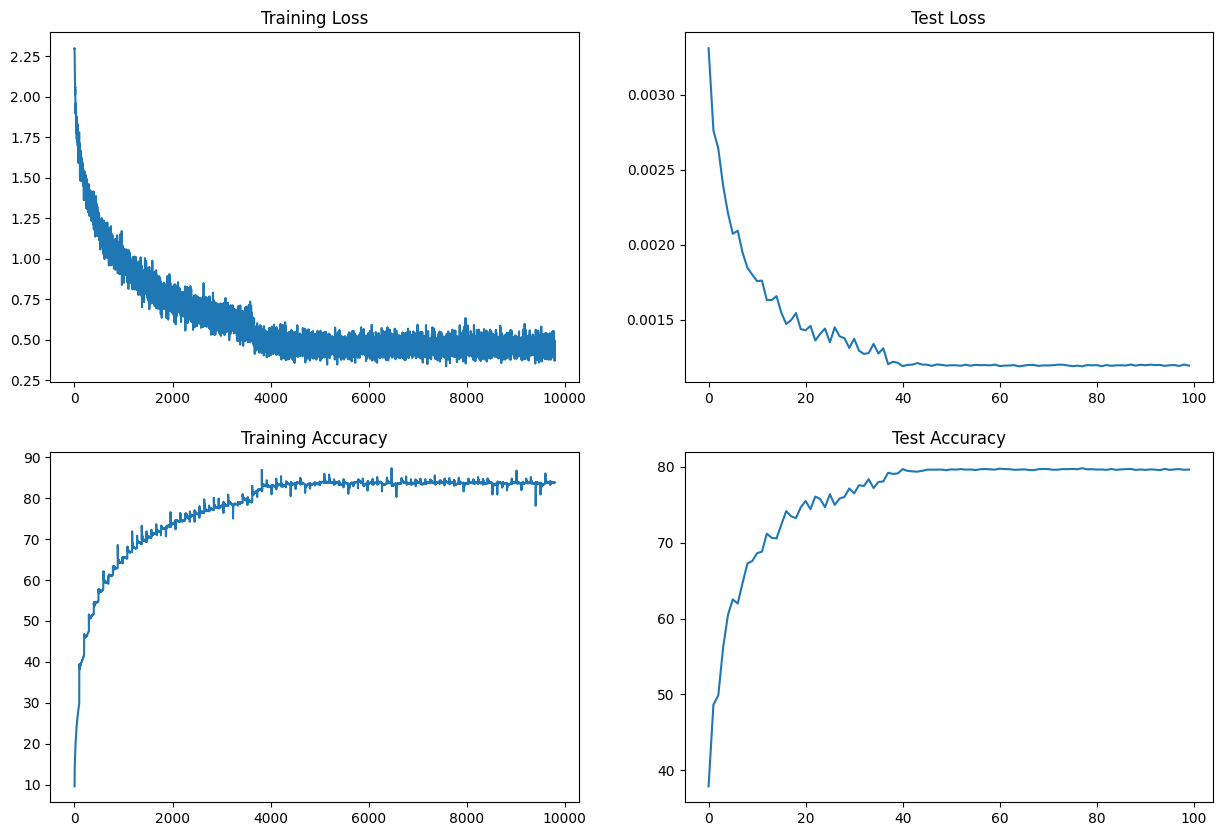

In [11]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

In [12]:
images, predictions, labels =  tester.get_misclassified_images()

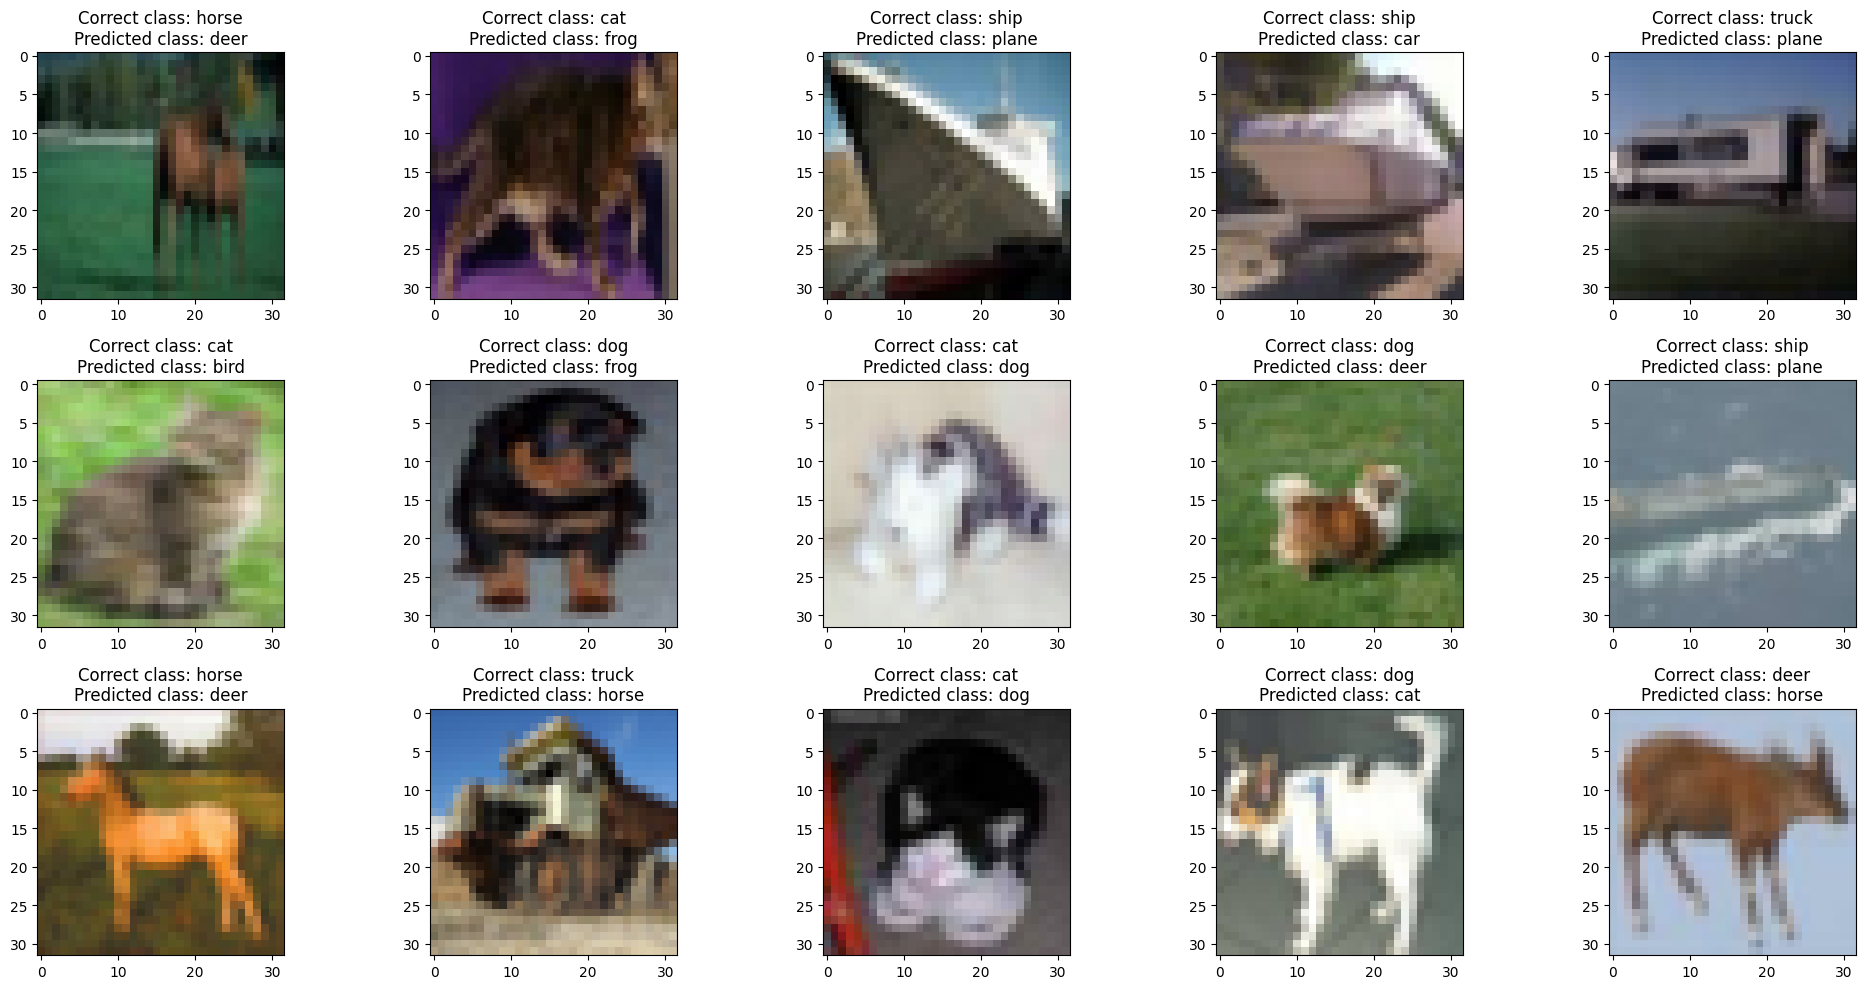

In [13]:
show_misclassified_images(images[:15],predictions[:15],labels[:15],cifar.classes)

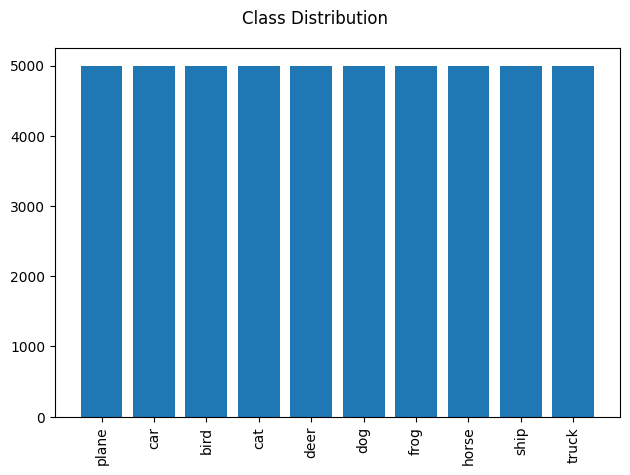

In [14]:
plot_class_distribution(train_loader,cifar.classes)

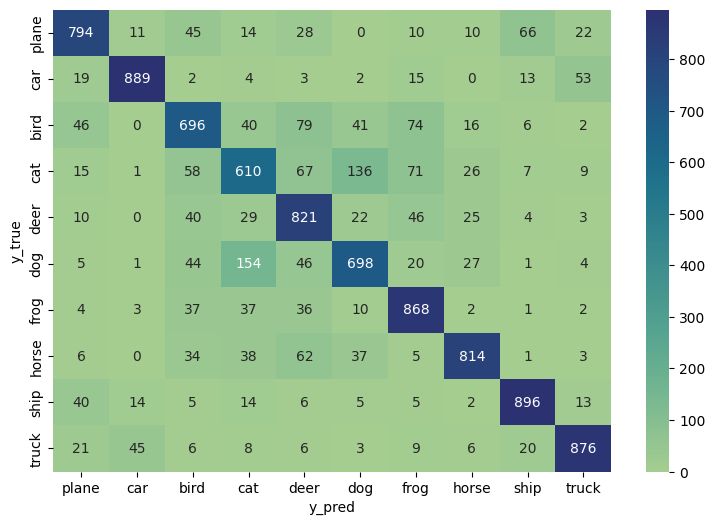

In [15]:
plot_confusion_matrix(model,test_loader,device,cifar.classes)

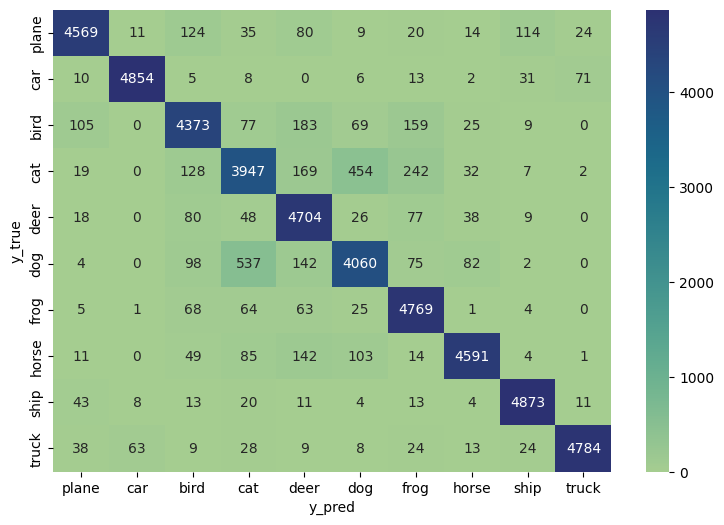

In [16]:
plot_confusion_matrix(model,train_loader,device,cifar.classes)